## CLUSTERING I: K-MEANS

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
# sys.path.append('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DATA_SCIENCE/CODE_REPOSITORY')
from linear_algebra import *
from gradient_descent import *
print 'IMPORT DONE'

IMPORT DONE


In [ ]:
# IDEA
#  given a dataset, choosing the # of cluster k in advance, and group the data into k clusters
#   S1,...,Sk such that the total sum of squared distance from each data point
#   to its assigned cluster.

### K-MEANS ALGORITHM
* 1, START WITH A SET OF K POINTS, which are points in d-dimensional space.
* 2, ASSIGN each point to the POINT to which it is CLOSEST.
* 3, COMPUTE a CENTROID for each of the clusters.
* 4, ASSIGN each point to the CENTROID to which it is CLOSEST.
* 5, if there's no change in assignment for any point, stop and keep the clusters, otherwise go to step 3.

In [9]:
class KMeans:
    
    def __init__(self, k):
        self.k = k
        self.means = None # centroids.
    
    def classify(self, new): 
        # return the index of the cluster closest to the new point.
        return min(range(self.k), key=lambda i: squared_distance(new, self.means[i]))
    
    def train(self, inputs):
        # initialize with k random points.
        self.means = random.sample(inputs, self.k)
        assignments = None
        # find new assignments.
        while True:
            newAssignments = map(self.classify, inputs)
            if assignments==newAssignments: return # means nothing has changed.
            assignments = newAssignments
            # compute new centroids based on new assignments.
            for i in range(self.k):
                # find all the points assigned to cluster i.
                iPoints = [p for p,a in zip(inputs, assignments) if a==i]
                # compute centroid for iPoints.
                if iPoints:
                    self.means[i] = vector_mean(iPoints)

### DEMO: IRIS

In [6]:
# LOAD DATA
from sklearn.datasets import load_iris
X, y = load_iris()['data'], load_iris()['target']
print X[:5], y[:5]

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]] [0 0 0 0 0]


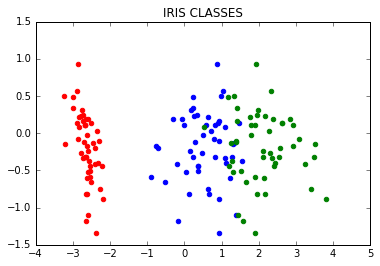

In [7]:
# PLOT IN COLOR BY CLASS
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)
Xclass0 = np.array([Xreduced[i] for i in range(len(X)) if y[i]==0])
Xclass1 = np.array([Xreduced[i] for i in range(len(X)) if y[i]==1])
Xclass2 = np.array([Xreduced[i] for i in range(len(X)) if y[i]==2])
plt.scatter(Xclass0[:,0],Xclass0[:,1],color='r')
plt.scatter(Xclass1[:,0],Xclass0[:,1],color='b')
plt.scatter(Xclass2[:,0],Xclass0[:,1],color='g')
plt.title('IRIS CLASSES')

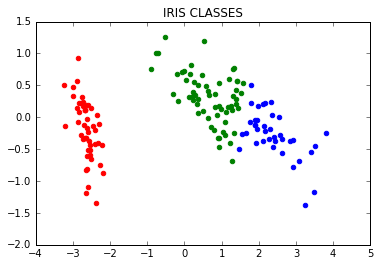

In [14]:
# CLUSTER -> PLOT FROM REDUCED DATA
kmeans1 = KMeans(3)
kmeans1.train(X)
yHat = [kmeans1.classify(X[i]) for i in range(len(X))]
X1class0 = np.array([Xreduced[i] for i in range(len(X)) if yHat[i]==0])
X1class1 = np.array([Xreduced[i] for i in range(len(X)) if yHat[i]==1])
X1class2 = np.array([Xreduced[i] for i in range(len(X)) if yHat[i]==2])
plt.scatter(X1class0[:,0],X1class0[:,1],color='r')
plt.scatter(X1class1[:,0],X1class1[:,1],color='b')
plt.scatter(X1class2[:,0],X1class2[:,1],color='g')
plt.title('IRIS CLASSES')
# NB: the results vary across initializations of first k points.

### EVALUATION

In [15]:
# ERROR MEASURE
def squared_clustering_errors(inputs, k):
    # finds the total squared error from k-means clustering the inputs.
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = map(clusterer.classify, inputs)
    return sum(squared_distance(input,means[cluster]) for input,cluster in zip(inputs,assignments))
        # assignments: class tags.

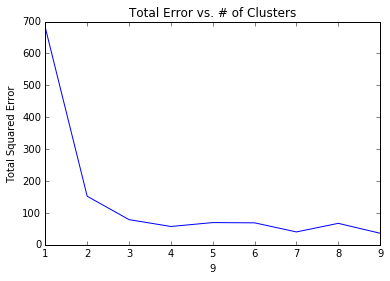

In [18]:
ks = range(1,10)
errors = [squared_clustering_errors(X, k) for k in ks]
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel(k)
plt.ylabel('Total Squared Error')
plt.title('Total Error vs. # of Clusters')

### APPLICATION: PICTURE "COMPRESSION"

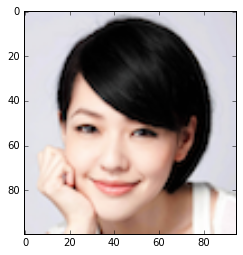

In [94]:
# IMAGE VECTORIZATION
#  img is a list of lists of lists:
#  img[i][j] is the pixel in the ith row and jth col, which is a list of [r, g, b].
#  NB: pixels are length-4 lists here, need to cut the last one out.
path = r'/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DATA_SCIENCE/DATA/dee_hsu.png'
import matplotlib.image as mpimg
img = mpimg.imread(path)
pixels = [pixel[:3] for row in img for pixel in row]
    # flatten image representation.
plt.imshow(img)

In [95]:
%%time
# MODEL (VEEEEERY LONG TRAIN TIME)
#  94*100 image took 11.6s
clusterer = KMeans(5)
clusterer.train(pixels)

CPU times: user 11 s, sys: 198 ms, total: 11.2 s
Wall time: 11.1 s


(-0.5, 94.5, 99.5, -0.5)

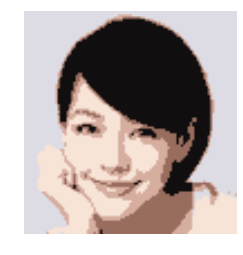

In [96]:
# RECONSTRUCTION
def recolor(pixel):
    # multiple-color -> 5-color transformation.
    cluster = clusterer.classify(pixel) # new we have a class tag.
    return clusterer.means[cluster] # return the centroid of that class.
imgTransformed = [[recolor(pixel) for pixel in row] for row in img]
plt.imshow(imgTransformed)
plt.axis('off')

## CLUSTERING II: HIERARCHICAL

In [102]:
# IDEA
#  merge data points by distance, bottom-up fashion, until single merging point is reached. 

In [103]:
# E.G. ELEMENTS
leaf1 = ([10, 20],) # 1-tuple needs comma.
leaf2 = ([30, -15],)
merged = (1, [leaf1, leaf2])

In [100]:
# ACCESSORS
def is_leaf(cluster): return len(cluster)==1
def get_children(cluster):
    # returns the two children of a cluster if it is a merged cluster,
    # raises an exception otherwise.
    if is_leaf(cluster): raise TypeError('A LEAF CLUSTER HAS NO CHILDREN')
    else: return cluster[1] # e.g. for (1, [leaf1, leaf2]), this returns [leaf1, leaf2].
def get_values(cluster):
    # returns value in leaf cluster.
    # returns all values of leaf clusters below non-leaf cluster.
    if is_leaf(cluster): return cluster
    else: return [value for child in get_children(cluster) for value in get_values(child)]

In [101]:
# CLUSTER DISTANCE MEASURE
#  distance: Euclidean.
#  scheme: min, max, avg.
def cluster_distance(cluster1, cluster2, distanceMSR=min):
    # compute all pairwise distances between two clusters, return all as a list.
    return distanceMSR([distance(input1,input2) for input1 in get_values(cluster1)
                                                for input2 in get_values(cluster2)])

In [104]:
# MERGE ORDER
#  smaller numbers represent LATER merges, 
#   so that when unmerge, do so from lowest merge to highest.
def get_merge_order(cluster):
    if is_leaf(cluster): return float('inf')
    else: return cluster[0] # merge order is first element of 2-tuple. e.g. (1, [leaf1, leaf2]).

In [180]:
# CLUSTERING FUNCTION
#  NB: inputs need to be 'list of lists', instead of 'np.ndarray'.
#   ndarray.tolist() to transform!
def hierarchical_cluster(inputs, distanceMSR=min):
    # input -> leaf.
    clusters = [(input,) for input in inputs]
    # while we have > 1 cluster left...
    while len(clusters) > 1:
        # find two closest clusters.
        c1, c2 = min([(cluster1,cluster2)
                      for i,cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]], # a way to get all combinations.
                      key=lambda (x,y): cluster_distance(x,y,distanceMSR))
        # remove them from list of clusters (they'll be merged).
        clusters = [c for c in clusters if c!=c1 and c!=c2]
        mergedCluster = (len(clusters), [c1,c2]) 
            # the later the merge takes place, the smaller the number.
            #  so that we get the merge order desired.
        clusters.append(mergedCluster)
    # return the only cluster left.
    return clusters[0]

### DEMO: IRIS
NB: Not the best option, because these are 4D data points.

In [181]:
# LOAD DATA
from sklearn.datasets import load_iris
X, y = load_iris()['data'], load_iris()['target']
print X[:5], y[:5]

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]] [0 0 0 0 0]


In [218]:
%%time
# UGLY TEXT REPRESENTATION OF CLUSTERING
clustering = hierarchical_cluster(X.tolist(),np.mean)

CPU times: user 13.4 s, sys: 45.2 ms, total: 13.4 s
Wall time: 13.4 s


In [219]:
# BETTER REPRESENTATION
def generate_clusters(clustering, numClusters):
    # start with a list with just the initial clustering.
    clusters = [clustering]
    # while we don't have enough clusters...
    while len(clusters) < numClusters: # numClusters cannot be > # of data points. this causes get_children exception.
        # choose the last-merged of clusters.
        nextCluster = min(clusters, key=get_merge_order) # recall, smaller in order = later merge.
        clusters = [c for c in clusters if c!=nextCluster] # remove it from list.
        clusters.extend(get_children(nextCluster)) # add its children to list.
    return clusters

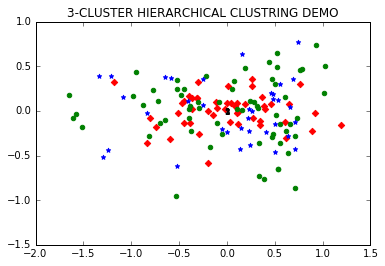

In [220]:
# DEMO: 3-CLUSTER, PLOT
#  scheme: average (i.e. np.mean).
#  NB: cluster needs to be 2-DIMENSION for plotting!!
threeClusters = [get_values(cluster) for cluster in generate_clusters(clustering, 3)]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
threeClustersReduced = [pca.fit_transform(cluster) for cluster in threeClusters]
for i,cluster,marker,color in zip([1,2,3], threeClustersReduced, ['D','o','*'], ['r','g','b']):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
        # main plot.
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')
        # put a number at the mean of the cluster.
    plt.title('3-CLUSTER HIERARCHICAL CLUSTRING DEMO')